# Setup

In [1]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Random seed
seed = 5993

In [2]:
# Run this once to download VADER lexicon (Hutto & Gilbert 2014)
# import nltk
# nltk.download('vader_lexicon')

In [3]:
# User options
cities = ["Houston", "New York"]
colors = {
    "Houston": "#1f77b4",
    "New York": "#ff7f0e"
} # pulled from default matplotlib colors

# Events to add to plot: (date, text, height from -100 to 100)
events = {
    "New York": [
        ("2020-03-01", "First reported\ncase in NYS", -40),
        ("2020-03-15", "NYC public schools\nordered to close", -30),
        ("2020-03-20", "Cuomo issues\nstay-at-home order", -50),
    ],
    "Houston": [
        ("2020-03-16", "First reported\ndeath in Texas", 40),
        ("2020-04-02", "Texas stay-at-home\norder begins", 40),
        ("2020-04-30", "Texas stay-at-home\norder ends", 40),
        ("2020-04-17", "Abbott announces\nend of SAH order", 40)
    ]
}

# Data import & cleaning

## Reddit

In [4]:
# Read in data
covid = pd.concat([
    pd.read_csv("../data/2020_reddit-comments_sampled-2020-05-13.csv.bz2"),
    pd.read_csv("../data/2019_reddit-comments_sampled-2020-05-13.csv.bz2")
])

# Normalize link ID
covid["link_id"] = covid["link_id"].str.replace("^t3_", "")

# Insert names of cities based on subreddit name
covid["city"] = covid["subreddit"].replace({
        "nyc": "New York",
        "houston": "Houston"
    })

covid["time"] = pd.to_datetime(covid["created_utc"], unit="s")

# Rename/drop columns
covid.rename(columns={
        "body": "text",
    }, inplace=True)
covid.drop(columns=["created_utc", "date"], inplace=True)

covid.head()

,text,link_id,score,subreddit,city,time
0,"Okay good, just making sure, I was lucky enoug...",fu1fbr,1,nyc,New York,2020-04-03 18:43:56
1,The poor markets and the poor workers.,fdhrs9,1,nyc,New York,2020-03-04 19:47:22
2,The numbers will just keep rising as more test...,fmdduh,1,nyc,New York,2020-03-22 12:46:36
3,Just get a bidet you savage,flmy15,1,nyc,New York,2020-03-20 13:21:21
4,I don't think there's been any study related t...,g6s9bc,1,nyc,New York,2020-04-24 00:44:25


## Twitter

In [5]:
# # Read in data
# df = pd.read_csv("../data/comments_sampled.csv")

# # Patterns to search for
# regexes = ["^(?:Texas|TX)", "^(?:NYC|New York|Bronx|Manhattan|Brooklyn|Queens|Staten Island)"]

# dfs = {}
# for city, regex in zip(cities, regexes):
#     # Create data frame
#     dfs[city] = pd.DataFrame()
    
#     # Subset original data
#     mask = df["Tweet Location"].str.contains(regex, na=False)
    
#     # Add columns
#     dfs[city]["id"] = df[mask]["Tweet Id"]
#     dfs[city]["text"] = df[mask]["Tweet Content"]
#     dfs[city]["city"] = city
#     dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
#     #dfs[city].set_index("id", inplace=True)

# # Compile dataframe with text
# covid = pd.concat(dfs).reset_index(drop=True)
# covid.set_index("id", inplace=True)

## EDA

In [53]:
covid["time"].dt.year.value_counts()

2019    90762
2020    42242
2014       37
2015       33
2012       30
Name: time, dtype: int64

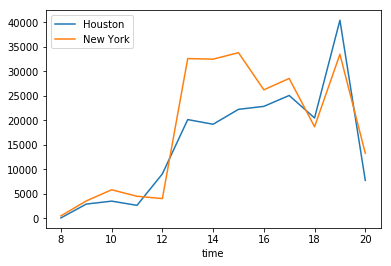

In [117]:
for city in cities:
    subset = covid[
        (covid["time"].dt.year == 2019) &
        (covid["city"] == city)
    ]
    subset \
        .groupby([subset["time"].dt.week]) \
        .sum()["score"].plot(label=city, legend="on");

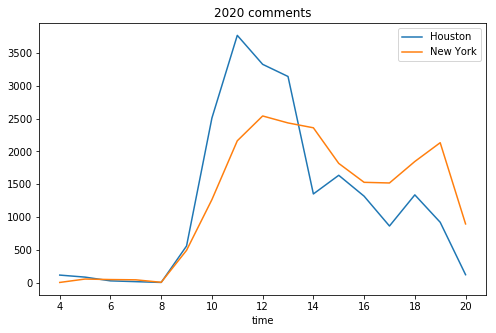

In [7]:
# Check if we're balanced across cities

for city in cities:
    subset = covid[(covid["time"].dt.year == 2020) & (covid["city"] == city)]
    subset.groupby(subset["time"].dt.week)["text"].count() \
    .plot(
        title = "2020 comments",
        color = colors[city],
        label = city,
        legend = "on",
        figsize = (8, 5)
    )

In [8]:
# Make sure we have sufficient data to graph on each keyword
for keyword in ["Cuomo", "Abbott", "Trump", "Fauci", "CDC"]:
    print(keyword)
    subset = covid[(covid["time"].dt.year == 2020) & (covid["text"].str.contains(keyword, case=False))]
    display(subset.groupby(subset["time"].dt.week)["text"].count())

Cuomo


time
9       2
10     12
11     23
12     76
13     87
14     74
15     38
16     54
17     56
18     67
19    157
20     62
Name: text, dtype: int64

Abbott


time
10     1
11     3
12    24
13    19
14     5
15     8
16    19
17    14
18    43
19    34
Name: text, dtype: int64

Trump


time
4      1
5      1
6      1
9     25
10    50
11    49
12    49
13    95
14    55
15    70
16    51
17    51
18    47
19    90
20    14
Name: text, dtype: int64

Fauci


time
9      2
10     2
11     3
12     1
13     7
14     8
15     3
16     4
17     1
18     5
19    13
20     5
Name: text, dtype: int64

CDC


time
4       2
5       4
6       3
9      62
10    103
11     91
12     45
13     33
14     16
15     15
16      9
17     11
18      8
19     25
20      1
Name: text, dtype: int64

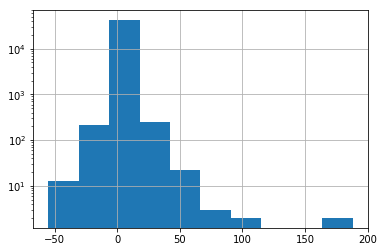

In [9]:
covid[covid["time"].dt.year == 2020]["score"].hist(log=True);

# Sentiment analysis

In [10]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

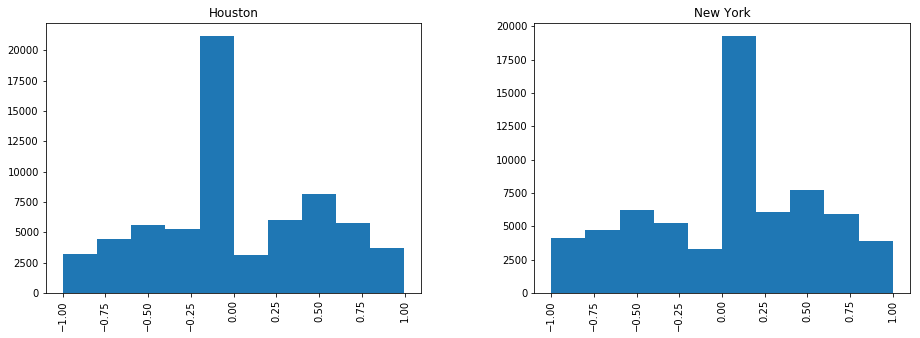

In [11]:
# Check distriution of sentiments by city;
covid.hist(column="compound", by="city", figsize=(15, 5));

In [45]:
# Define weighting scheme, with a "scaling back" factor to temper the range of the graphs
covid["score_weighted"] = covid["compound"] * covid["score"] * 0.75

In [46]:
# Define sentiment intensity
covid["intensity"] = np.abs(covid["score_weighted"])

# Graphs

In [49]:
def plt_setup(ax, title, year, xlabel="", ylabel=""):
    """Set up matplotlib graph with standard settings"""
    ax.set_title(title, fontsize=28)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.xaxis_date()
    ax.set_xlim((
            covid[covid["time"].dt.year == year]["time"].min() - pd.DateOffset(2),
            covid[covid["time"].dt.year == year]["time"].max() + pd.DateOffset(2)
        ))
    ax.set_xticks(
        list(filter(lambda x: x.day == 1,
               pd.date_range(
                covid[covid["time"].dt.year == year]["time"].min() - pd.DateOffset(2),
                covid[covid["time"].dt.year == year]["time"].max() + pd.DateOffset(2)
            ))))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_ylim((-100, 100))
    ax.set_yticks([-66.667, 66.667])
    ax.set_yticklabels(["☹", "☺"], fontsize=28)

    ax.axhline(0, color="gray")

def plt_city(ax, df, city, weight=False):
    """Plot a line graph of sentiment for a given city with given data df"""
    column = "score_weighted" if weight else "compound"
    
    # Draw line plot
    if df.shape[0] > 2:
        ax.plot(
            df.index,
            df[column] * 100,
            linewidth = 3,
            color = colors[city],
            label = ""
        );
        # Annotations
        ax.text(
            x = df.index[0],
            y = df[column][0] * 100 + 5,
            s = city,
            fontsize = 20,
            horizontalalignment = "center"
        )    

def plt_add_events(ax, events):
    """Plot events, timeline-style, along the x-axis"""
    for city in cities:
        for event in events[city]:
            ax.text(
                x = pd.to_datetime(event[0]),
                y = event[2],
                s = event[1],
                fontsize = 12,
                color = colors[city]
            )
            ax.vlines(
                x = pd.to_datetime(event[0]),
                ymin = event[2],
                ymax = -100,
                linestyle = ":"
            )

## Old comments

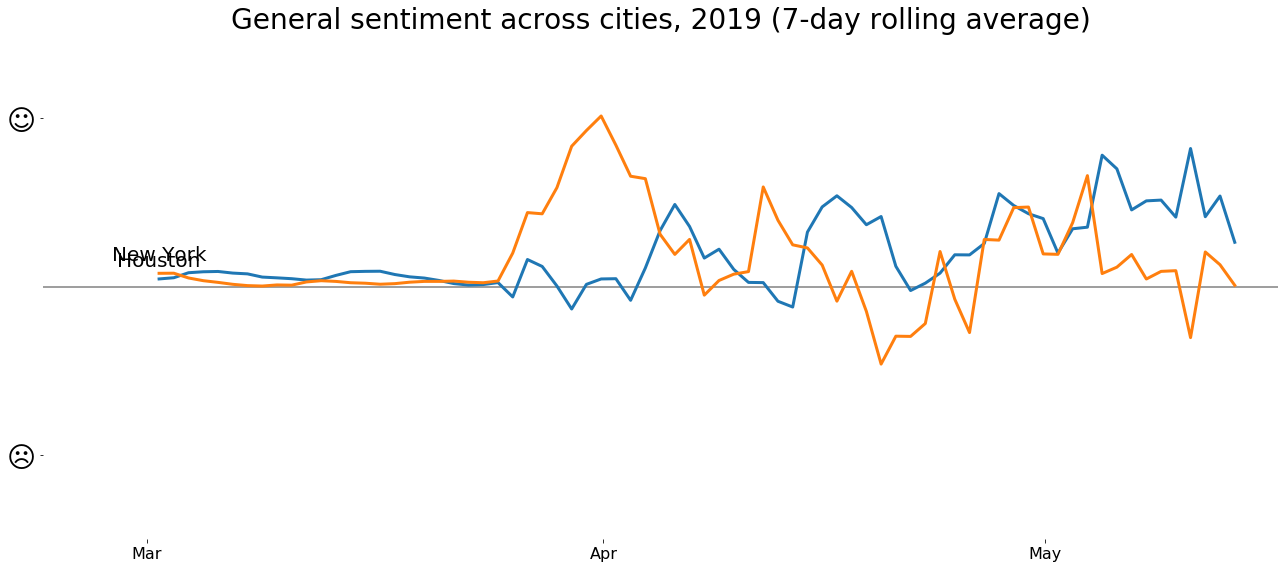

In [52]:
rolling = 7
year = 2019

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"General sentiment across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:

    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)
    
    # Write out
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-Citywide-{year}-{rolling}day.svg", transparent=True)

## Citywide

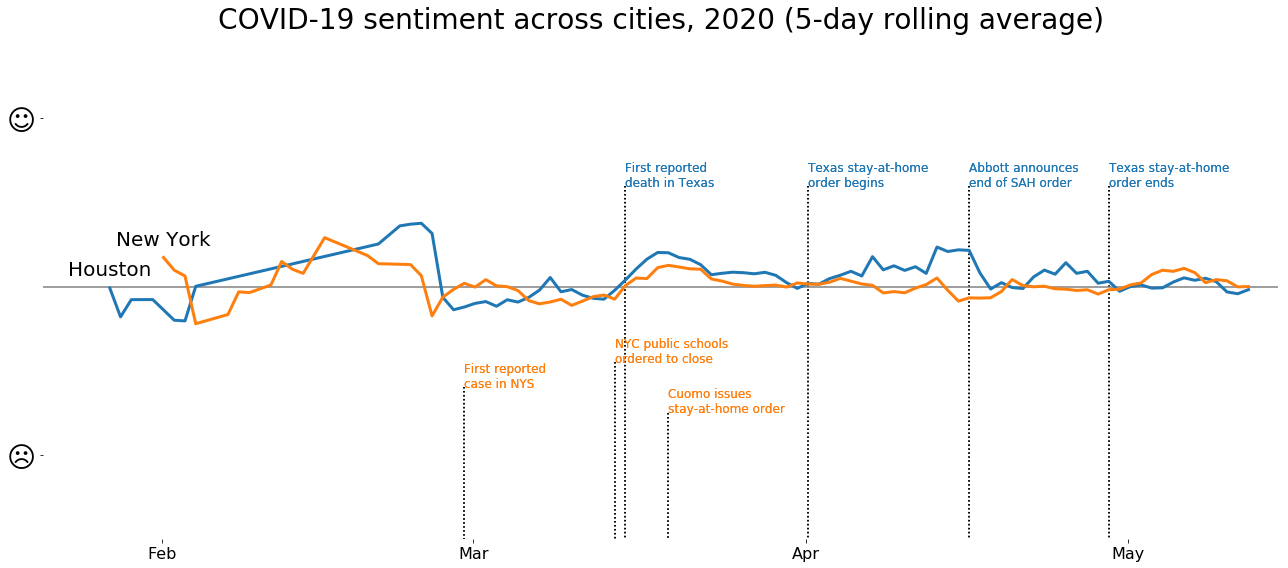

In [42]:
rolling = 5
year = 2020

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"COVID-19 sentiment across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:

    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)
    
    # Events
    plt_add_events(ax, events)
    
    # Write out
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-Citywide-{year}-{rolling}day.svg", transparent=True)

## Governors

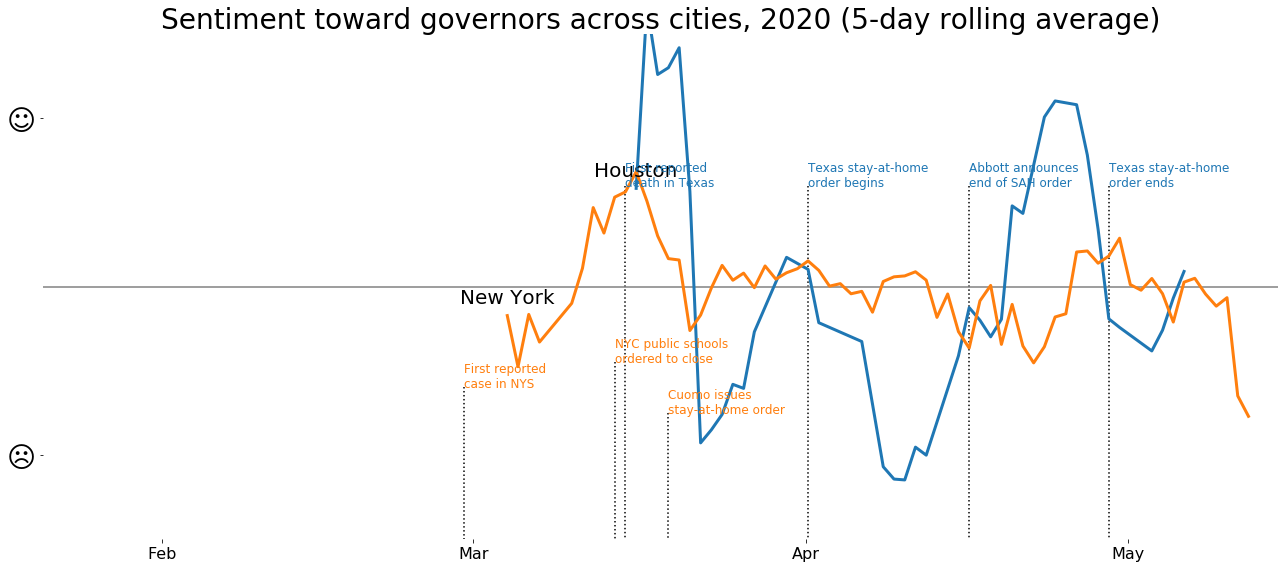

In [43]:
governors = {
    "New York": "Cuomo",
    "Houston": "Abbott"
}
rolling = 5
year = 2020

# Configure plots
fig, ax = plt.subplots(figsize=(18, 8))
plt_setup(ax, f"Sentiment toward governors across cities, {year} ({rolling}-day rolling average)", year)

for city in cities:
    # Gather data
    subset = covid[
        (covid["time"].dt.year == year) &
        (covid["city"] == city) &
        (covid["text"].str.contains(governors[city], case=False)) &
        (covid["score"] > 0)
    ]
    subset_mean = subset\
        .groupby(subset["time"].dt.date) \
        .mean() \
        .rolling(rolling) \
        .mean() \
        .dropna()
    
    # Line plots
    plt_city(ax, subset_mean, city, weight=True)

# Events
plt_add_events(ax, events)
    
# Write out
plt.tight_layout()
plt.savefig(f"../graphs/Sentiment-Governors-{rolling}day.svg", transparent=True)

## National figures

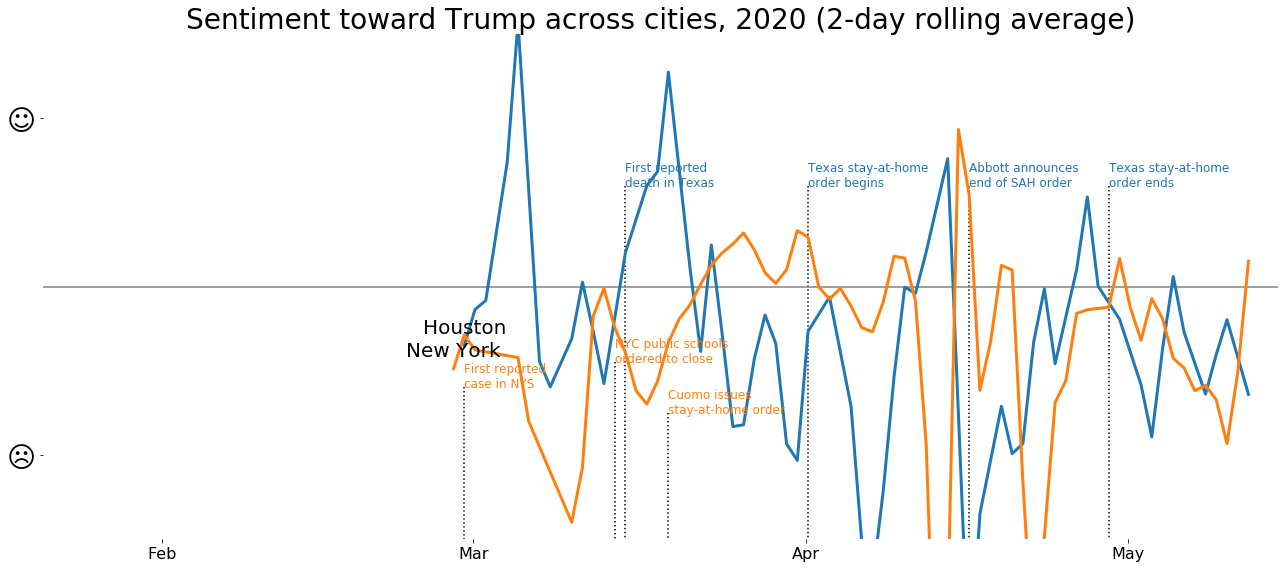

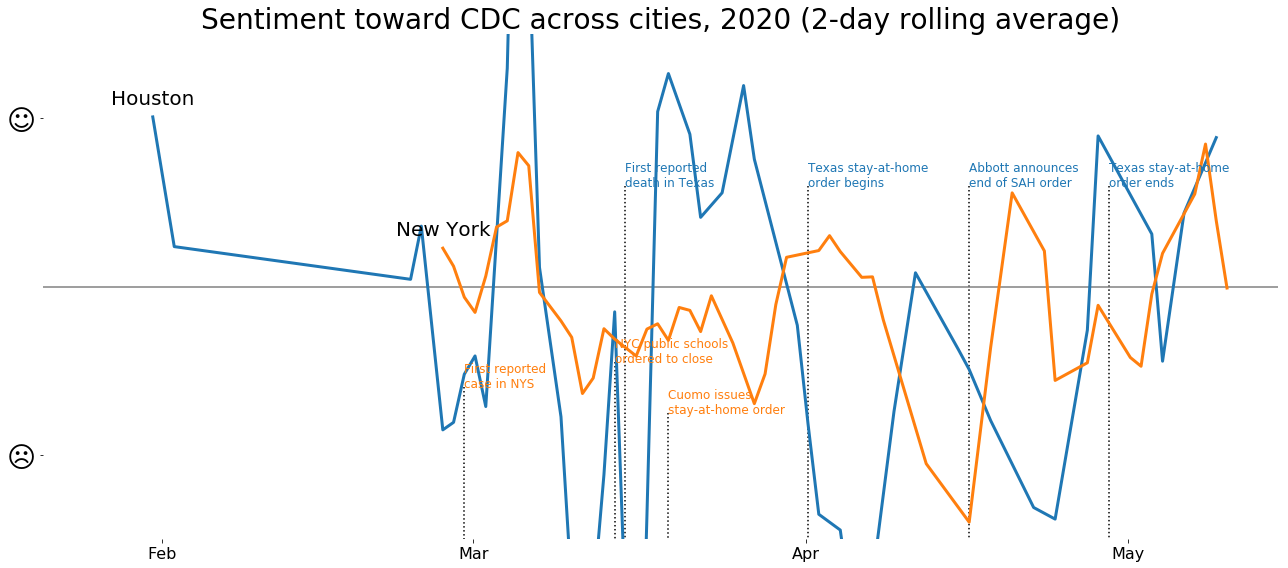

In [44]:
rolling = 2
year = 2020

for keyword in ["Trump", "CDC"]:

    # Configure plots
    fig, ax = plt.subplots(figsize=(18, 8))        
    plt_setup(ax, f"Sentiment toward {keyword} across cities, {year} ({rolling}-day rolling average)", year)

    for city in cities:
        # Gather data
        subset = covid[
            (covid["time"].dt.year == year) &
            (covid["city"] == city) &
            (covid["text"].str.contains(keyword, case=False)) &
            (covid["score"] > 0)
        ]
        subset_mean = subset\
            .groupby(subset["time"].dt.date) \
            .mean() \
            .rolling(rolling) \
            .mean() \
            .dropna()

        # Line plots
        plt_city(ax, subset_mean.rolling(rolling).mean().dropna(), city, weight=True)

    # Events
    plt_add_events(ax, events)
    
    # Write out
    plt.tight_layout()
    plt.savefig(f"../graphs/Sentiment-{keyword}-{rolling}day.svg", transparent=True)

# References

Hutto, C. J. and Gilbert, E. E. Aug. 2014. [VADER: A parsimonious rule-based model for sentiment analysis of social media text.](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/view/8109) In Adar, E., Resnick, P., Choudhury, M. D., Hogan, B., and Oh, A. H., eds., *Proceedings of the Eighth International Conference on Weblogs and Social Media*, pp. 216–225. Palo Alto, CA: AAAI Press

In [68]:
covid[
    (covid["city"] == "New York") &
    (covid["time"].dt.year == 2019) &
    (covid["time"].dt.week == 10)
].groupby("link_id").sum().sort_values("score_weighted", ascending=False)

,score,neg,neu,pos,compound,score_weighted,intensity
link_id,,,,,,,
ayifus,338,21.492,277.469,39.036,43.0867,32.315025,102.476925
ay3edy,199,14.062,163.700,21.246,34.0596,25.544700,63.048600
ayu1rs,163,14.383,121.749,25.870,30.5285,22.896375,46.182525
azeprm,53,2.221,38.024,12.755,18.9333,14.199975,16.873875
axqe1b,171,17.675,130.068,23.259,16.6513,12.488475,55.422525
ay6gj7,72,6.564,50.805,14.631,14.5525,10.914375,27.677025
ay2sfe,677,67.475,517.970,87.561,11.9717,8.978775,211.407375
axpa7n,52,2.162,43.220,6.616,9.6118,7.208850,12.628200
ayqdsc,104,6.858,85.844,11.297,9.4174,7.063050,25.318500
